# 2. Import libraries and read data

In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [2]:
from joblib import Parallel, delayed
from joblib import parallel_backend

In [3]:
df = pd.read_csv("data_resampled_5.csv")

### 4.1.3 Cross Vallidation

In [4]:
majority_class = df[df['Outcome'] == 0]
minority_class = df[df['Outcome'] == 1]

# Define the number of samples to select
n_samples = 50

# Perform random sampling
sampled_majority = majority_class.sample(n_samples, random_state=123)
sampled_minority = minority_class.sample(n_samples, random_state=123)

# Combine sampled data
sampled_df = pd.concat([sampled_majority, sampled_minority])
sampled_df

#test
y_test = sampled_df['Outcome']
x_test = sampled_df.drop(columns='Outcome')

# train
# Separate remaining data for training
remaining_df = df.drop(sampled_df.index)
y_train = remaining_df['Outcome']
x_train= remaining_df.drop(columns='Outcome')

scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

In [5]:
#from sklearn.model_selection import RepeatedKFold
rs=123
cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=345)

## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [6]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [7]:
# Creating and running our optimization
study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=100)

[I 2024-08-26 01:40:59,854] A new study created in memory with name: KNN
[I 2024-08-26 01:41:00,854] Trial 0 finished with value: 0.5166846765043525 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'auto', 'leaf_size': 55}. Best is trial 0 with value: 0.5166846765043525.
[I 2024-08-26 01:41:06,512] Trial 1 finished with value: 0.49972075768956825 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'minkowski', 'p': 40, 'algorithm': 'brute', 'leaf_size': 56}. Best is trial 0 with value: 0.5166846765043525.
[I 2024-08-26 01:41:12,205] Trial 2 finished with value: 0.5163912634119372 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'minkowski', 'p': 38, 'algorithm': 'brute', 'leaf_size': 27}. Best is trial 0 with value: 0.5166846765043525.
[I 2024-08-26 01:41:17,924] Trial 3 finished with value: 0.5143929538070431 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'minkowski', 'p': 32

[I 2024-08-26 01:42:14,507] Trial 32 finished with value: 0.7931453703326623 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 22, 'algorithm': 'kd_tree', 'leaf_size': 35}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:42:15,691] Trial 33 finished with value: 0.6712266795258072 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 33}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:42:20,610] Trial 34 finished with value: 0.7264138259398493 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski', 'p': 24, 'algorithm': 'brute', 'leaf_size': 14}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:42:21,657] Trial 35 finished with value: 0.5892961241576411 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'brute', 'leaf_size': 60}. Best is trial 17 wit

[I 2024-08-26 01:43:47,258] Trial 64 finished with value: 0.6932082402368214 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 41}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:43:48,120] Trial 65 finished with value: 0.6932082402368214 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 46}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:43:49,561] Trial 66 finished with value: 0.6115902626443647 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 50}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:43:52,108] Trial 67 finished with value: 0.49020769284320637 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 36}. Best is trial 17 w

[I 2024-08-26 01:44:21,554] Trial 96 finished with value: 0.636779833907946 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'auto', 'leaf_size': 35}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:44:23,283] Trial 97 finished with value: 0.7089008152093945 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 43}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:44:24,668] Trial 98 finished with value: 0.6100230025553376 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 16, 'algorithm': 'auto', 'leaf_size': 28}. Best is trial 17 with value: 0.7931453703326623.
[I 2024-08-26 01:44:25,341] Trial 99 finished with value: 0.7393113125192186 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'auto', 'leaf_size': 26}. Best is trial 17 with v

In [8]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 17
Best accuracy: 0.7931453703326623
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 13, 'algorithm': 'kd_tree', 'leaf_size': 70}


              precision    recall  f1-score   support

           0     0.7143    1.0000    0.8333        50
           1     1.0000    0.6000    0.7500        50

    accuracy                         0.8000       100
   macro avg     0.8571    0.8000    0.7917       100
weighted avg     0.8571    0.8000    0.7917       100



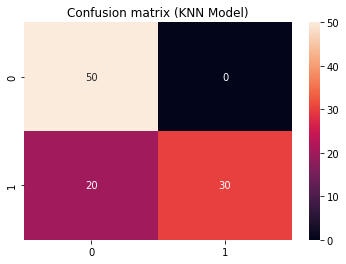

In [39]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred, digits=4))
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

Accuracy: 0.8000
Precision: 1.0000
Recall: 0.6000
F1 Score: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        50
           1       1.00      0.60      0.75        50

    accuracy                           0.80       100
   macro avg       0.86      0.80      0.79       100
weighted avg       0.86      0.80      0.79       100



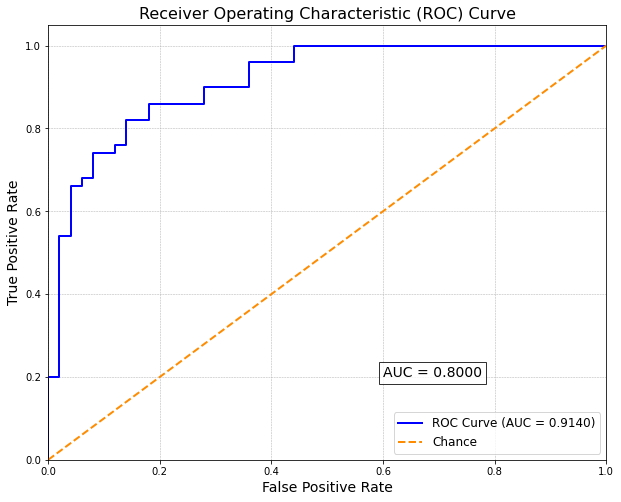

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, classification_report

# Get the best parameters from the Optuna study and train the KNN model
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(x_train_, y_train)

# Predict on the test set
y_pred = best_knn.predict(x_test_)
y_proba = best_knn.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_knn:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


## 4.3 Logistic Regression

Accuracy: 0.5100
Precision: 1.0000
Recall: 0.0200
F1 Score: 0.0392

Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        50
           1       1.00      0.02      0.04        50

    accuracy                           0.51       100
   macro avg       0.75      0.51      0.36       100
weighted avg       0.75      0.51      0.36       100



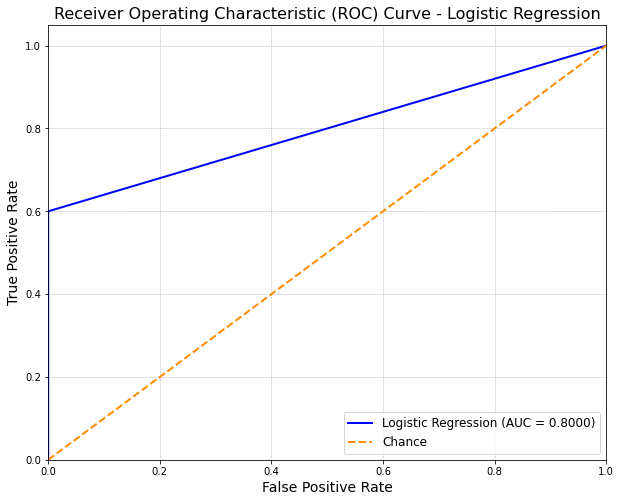

In [48]:
# Predict on the test set
y_pred_lr = LR.predict(x_test_)
y_proba_lr = LR.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

In [12]:
# Creating and running our optimization

study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=100)

[I 2024-08-26 01:44:25,659] A new study created in memory with name: logr
[I 2024-08-26 01:44:26,652] Trial 0 finished with value: 0.5676532416417086 and parameters: {'C': 0.1312008120867196, 'solver': 'liblinear', 'max_iter': 418}. Best is trial 0 with value: 0.5676532416417086.
[I 2024-08-26 01:44:31,290] Trial 1 finished with value: 0.5671355781855817 and parameters: {'C': 0.0010617877198744298, 'solver': 'lbfgs', 'max_iter': 970}. Best is trial 0 with value: 0.5676532416417086.
[I 2024-08-26 01:44:45,110] Trial 2 finished with value: 0.4747297969738738 and parameters: {'C': 1.0869327994843763, 'solver': 'saga', 'max_iter': 641}. Best is trial 0 with value: 0.5676532416417086.
[I 2024-08-26 01:44:47,982] Trial 3 finished with value: 0.5727742702902173 and parameters: {'C': 4.5657339795380185, 'solver': 'lbfgs', 'max_iter': 375}. Best is trial 3 with value: 0.5727742702902173.
[I 2024-08-26 01:44:50,669] Trial 4 finished with value: 0.5715497705537923 and parameters: {'C': 0.01835961

[I 2024-08-26 01:48:15,633] Trial 40 finished with value: 0.395508021127306 and parameters: {'C': 0.02139324680148101, 'solver': 'sag', 'max_iter': 121}. Best is trial 26 with value: 0.573516667205265.
[I 2024-08-26 01:48:20,641] Trial 41 finished with value: 0.5731865372534024 and parameters: {'C': 0.07997926669810541, 'solver': 'newton-cg', 'max_iter': 244}. Best is trial 26 with value: 0.573516667205265.
[I 2024-08-26 01:48:25,467] Trial 42 finished with value: 0.5733631848784777 and parameters: {'C': 0.11335988763070036, 'solver': 'newton-cg', 'max_iter': 282}. Best is trial 26 with value: 0.573516667205265.
[I 2024-08-26 01:48:28,691] Trial 43 finished with value: 0.5732754055386551 and parameters: {'C': 0.701086364939296, 'solver': 'newton-cg', 'max_iter': 321}. Best is trial 26 with value: 0.573516667205265.
[I 2024-08-26 01:48:31,762] Trial 44 finished with value: 0.5727713079327185 and parameters: {'C': 1.7083153632558474, 'solver': 'newton-cg', 'max_iter': 417}. Best is trial

[I 2024-08-26 01:51:01,671] Trial 80 finished with value: 0.5731629126436086 and parameters: {'C': 0.33904626256362513, 'solver': 'newton-cg', 'max_iter': 782}. Best is trial 26 with value: 0.573516667205265.
[I 2024-08-26 01:51:04,704] Trial 81 finished with value: 0.5732020903181269 and parameters: {'C': 0.15558395903238093, 'solver': 'newton-cg', 'max_iter': 555}. Best is trial 26 with value: 0.573516667205265.
[I 2024-08-26 01:51:07,872] Trial 82 finished with value: 0.5734499833296227 and parameters: {'C': 0.203161541162012, 'solver': 'newton-cg', 'max_iter': 609}. Best is trial 26 with value: 0.573516667205265.
[I 2024-08-26 01:51:10,998] Trial 83 finished with value: 0.5731726221588023 and parameters: {'C': 0.3937898347721702, 'solver': 'newton-cg', 'max_iter': 609}. Best is trial 26 with value: 0.573516667205265.
[I 2024-08-26 01:51:14,108] Trial 84 finished with value: 0.5732188720009752 and parameters: {'C': 0.27140661778939995, 'solver': 'newton-cg', 'max_iter': 563}. Best i

In [13]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 26
Best accuracy: 0.573516667205265
Best hyperparameters: {'C': 0.20882220538244406, 'solver': 'newton-cg', 'max_iter': 144}


              precision    recall  f1-score   support

           0       0.51      1.00      0.67        50
           1       1.00      0.02      0.04        50

    accuracy                           0.51       100
   macro avg       0.75      0.51      0.36       100
weighted avg       0.75      0.51      0.36       100



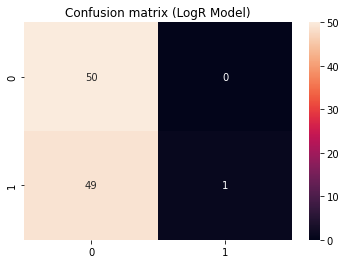

In [14]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr, cm_title = "Confusion matrix (LogR Model)")

Accuracy: 0.5100
Precision: 1.0000
Recall: 0.0200
F1 Score: 0.0392

Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        50
           1       1.00      0.02      0.04        50

    accuracy                           0.51       100
   macro avg       0.75      0.51      0.36       100
weighted avg       0.75      0.51      0.36       100



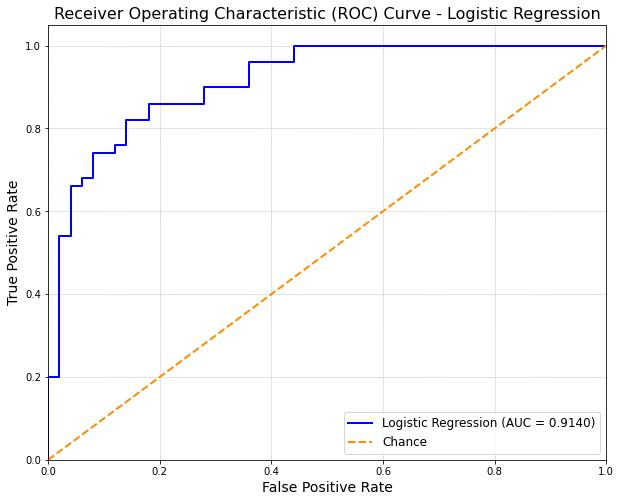

In [15]:
# Predict on the test set
y_pred_lr = LR.predict(x_test_)
y_proba_lr = LR.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.4 Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [17]:
# Creating and running our optimization

study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
study_dect.optimize(objective_dect, n_trials=100)

[I 2024-08-26 01:52:14,439] A new study created in memory with name: Dect
[I 2024-08-26 01:52:15,032] Trial 0 finished with value: 0.26837064534735694 and parameters: {'max_depth': 56, 'ccp_alpha': 2.208201356493499, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.26837064534735694.
[I 2024-08-26 01:52:15,383] Trial 1 finished with value: 0.26837064534735694 and parameters: {'max_depth': 34, 'ccp_alpha': 0.7867455076183821, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 0 with value: 0.26837064534735694.
[I 2024-08-26 01:52:15,806] Trial 2 finished with value: 0.26837064534735694 and parameters: {'max_depth': 42, 'ccp_alpha': 0.3993883895645247, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.26837064534735694.
[I 2024-08-26 01:52:16,201] Trial 3 finished with value: 0.5

[I 2024-08-26 01:52:27,055] Trial 28 finished with value: 0.5989141390296258 and parameters: {'max_depth': 42, 'ccp_alpha': 0.05751014140019162, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 24 with value: 0.7523662342898259.
[I 2024-08-26 01:52:27,467] Trial 29 finished with value: 0.6538743744168168 and parameters: {'max_depth': 28, 'ccp_alpha': 0.0017181358030499234, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 24 with value: 0.7523662342898259.
[I 2024-08-26 01:52:27,884] Trial 30 finished with value: 0.6210779048348415 and parameters: {'max_depth': 39, 'ccp_alpha': 0.015606047122488568, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 24 with value: 0.7523662342898259.
[I 2024-08-26 01:52:28,305] Trial 31 finished with value: 0.6641469188825434 and parameters: {'max_depth': 52, 'ccp_alpha'

[I 2024-08-26 01:52:39,230] Trial 57 finished with value: 0.6295713759514208 and parameters: {'max_depth': 44, 'ccp_alpha': 0.013908803074435844, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 44 with value: 0.8003693376906658.
[I 2024-08-26 01:52:39,682] Trial 58 finished with value: 0.6924880146962569 and parameters: {'max_depth': 36, 'ccp_alpha': 0.0019481285277455393, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 44 with value: 0.8003693376906658.
[I 2024-08-26 01:52:40,105] Trial 59 finished with value: 0.7100260694679054 and parameters: {'max_depth': 53, 'ccp_alpha': 0.0010049215529671922, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 44 with value: 0.8003693376906658.
[I 2024-08-26 01:52:40,601] Trial 60 finished with value: 0.6567164188081991 and parameters: {'max_depth': 64, 'ccp_alpha': 0.0

[I 2024-08-26 01:52:52,750] Trial 86 finished with value: 0.692314674283315 and parameters: {'max_depth': 41, 'ccp_alpha': 0.0017630820856691677, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 44 with value: 0.8003693376906658.
[I 2024-08-26 01:52:53,283] Trial 87 finished with value: 0.5569559205217051 and parameters: {'max_depth': 35, 'ccp_alpha': 0.026170818156942548, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 44 with value: 0.8003693376906658.
[I 2024-08-26 01:52:53,800] Trial 88 finished with value: 0.5989141390296258 and parameters: {'max_depth': 38, 'ccp_alpha': 0.19844938876330273, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 44 with value: 0.8003693376906658.
[I 2024-08-26 01:52:54,325] Trial 89 finished with value: 0.7063734530767575 and parameters: {'max_depth': 40, 'ccp_alpha': 0.00

In [18]:
# Evaluating our Optuna Trial
print("Best trial:", study_dect.best_trial.number)
print("Best accuracy:", study_dect.best_trial.value)
print("Best hyperparameters:", study_dect.best_params)

Best trial: 44
Best accuracy: 0.8003693376906658
Best hyperparameters: {'max_depth': 64, 'ccp_alpha': 0.0014316775594807715, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'entropy'}


              precision    recall  f1-score   support

           0       0.78      1.00      0.88        50
           1       1.00      0.72      0.84        50

    accuracy                           0.86       100
   macro avg       0.89      0.86      0.86       100
weighted avg       0.89      0.86      0.86       100



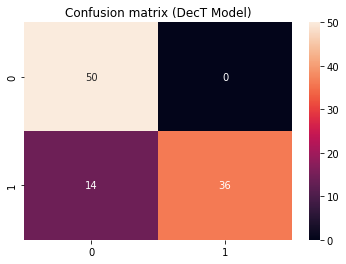

In [19]:
best_param_dect = study_dect.best_params
DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
y_pred_dect = DecT.predict(x_test)
    

display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")

Accuracy: 0.8400
Precision: 1.0000
Recall: 0.6800
F1 Score: 0.8095

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        50
           1       1.00      0.68      0.81        50

    accuracy                           0.84       100
   macro avg       0.88      0.84      0.84       100
weighted avg       0.88      0.84      0.84       100



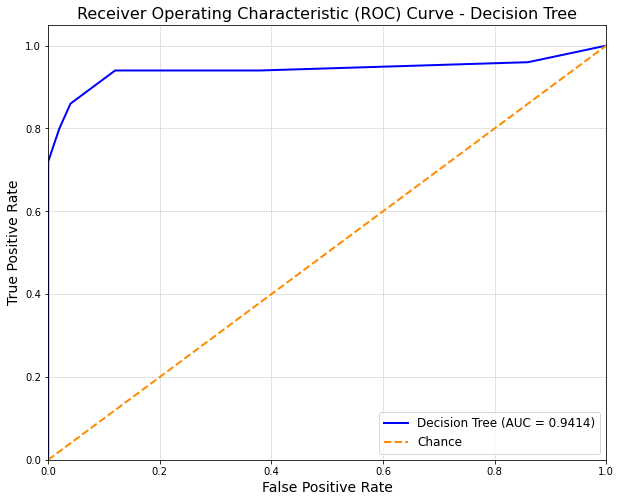

In [20]:
# Train the best Decision Tree model
best_param_dect = study_dect.best_params
best_dect = DecisionTreeClassifier(**best_param_dect, random_state=123)
best_dect.fit(x_train_, y_train)

# Predict on the test set
y_pred_dect = best_dect.predict(x_test_)
y_proba_dect = best_dect.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_dect = accuracy_score(y_test, y_pred_dect)
precision_dect = precision_score(y_test, y_pred_dect)
recall_dect = recall_score(y_test, y_pred_dect)
f1_dect = f1_score(y_test, y_pred_dect)

print(f"Accuracy: {accuracy_dect:.4f}")
print(f"Precision: {precision_dect:.4f}")
print(f"Recall: {recall_dect:.4f}")
print(f"F1 Score: {f1_dect:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dect))

# Plot the ROC curve
fpr_dect, tpr_dect, _ = roc_curve(y_test, y_proba_dect)
roc_auc_dect = auc(fpr_dect, tpr_dect)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dect, tpr_dect, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.5 SVM (Support Vector Machine)

In [21]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [22]:
# Creating and running our optimization

study_svm = optuna.create_study(direction='maximize',study_name ="SVM")
study_svm.optimize(objective_svm, n_trials=100)

[I 2024-08-26 01:52:59,827] A new study created in memory with name: SVM
[I 2024-08-26 01:53:21,960] Trial 0 finished with value: 0.659657622032195 and parameters: {'C': 0.42376681261635746, 'gamma': 0.7483605320662206}. Best is trial 0 with value: 0.659657622032195.
[I 2024-08-26 01:54:03,274] Trial 1 finished with value: 0.5905105144441846 and parameters: {'C': 81.44332223105609, 'gamma': 0.0001534191014372132}. Best is trial 0 with value: 0.659657622032195.
[I 2024-08-26 01:54:39,833] Trial 2 finished with value: 0.6195366159814274 and parameters: {'C': 0.1333566863820398, 'gamma': 0.04381570084972314}. Best is trial 0 with value: 0.659657622032195.
[I 2024-08-26 01:55:10,341] Trial 3 finished with value: 0.6589204622873982 and parameters: {'C': 0.42168610762984793, 'gamma': 0.049044451890068556}. Best is trial 0 with value: 0.659657622032195.
[I 2024-08-26 01:55:51,804] Trial 4 finished with value: 0.5886061824480355 and parameters: {'C': 1.801634815079527, 'gamma': 0.0009787643464

[I 2024-08-26 02:13:37,680] Trial 41 finished with value: 0.8480222695792117 and parameters: {'C': 338.9843966114341, 'gamma': 0.087814674212826}. Best is trial 41 with value: 0.8480222695792117.
[I 2024-08-26 02:14:00,404] Trial 42 finished with value: 0.7940255282716444 and parameters: {'C': 172.20331381927357, 'gamma': 0.0434540467439051}. Best is trial 41 with value: 0.8480222695792117.
[I 2024-08-26 02:14:11,220] Trial 43 finished with value: 0.8468955293013236 and parameters: {'C': 351.05677802180793, 'gamma': 0.0984349162738087}. Best is trial 41 with value: 0.8480222695792117.
[I 2024-08-26 02:14:43,255] Trial 44 finished with value: 0.7446866979107188 and parameters: {'C': 300.38490585200356, 'gamma': 0.028654490828827373}. Best is trial 41 with value: 0.8480222695792117.
[I 2024-08-26 02:14:53,868] Trial 45 finished with value: 0.848475241047816 and parameters: {'C': 151.04897477312858, 'gamma': 0.10224186813656576}. Best is trial 45 with value: 0.848475241047816.
[I 2024-08-

[I 2024-08-26 02:25:53,563] Trial 83 finished with value: 0.8435296584807671 and parameters: {'C': 444.8908310887503, 'gamma': 0.2430966050602498}. Best is trial 69 with value: 0.853396565086433.
[I 2024-08-26 02:26:02,990] Trial 84 finished with value: 0.8471101698696982 and parameters: {'C': 269.8177854402464, 'gamma': 0.13252215230728195}. Best is trial 69 with value: 0.853396565086433.
[I 2024-08-26 02:26:29,447] Trial 85 finished with value: 0.8246512188865932 and parameters: {'C': 715.8408015902286, 'gamma': 0.041371724220411084}. Best is trial 69 with value: 0.853396565086433.
[I 2024-08-26 02:26:40,965] Trial 86 finished with value: 0.8104268585174883 and parameters: {'C': 463.3244269849611, 'gamma': 0.39585542887712966}. Best is trial 69 with value: 0.853396565086433.
[I 2024-08-26 02:27:21,400] Trial 87 finished with value: 0.5876929970125966 and parameters: {'C': 212.95775089831653, 'gamma': 3.936688797190104e-05}. Best is trial 69 with value: 0.853396565086433.
[I 2024-08-2

In [23]:
# Evaluating our Optuna Trial
print("Best trial:", study_svm.best_trial.number)
print("Best accuracy:", study_svm.best_trial.value)
print("Best hyperparameters:", study_svm.best_params)

Best trial: 69
Best accuracy: 0.853396565086433
Best hyperparameters: {'C': 827.2378675011503, 'gamma': 0.1403362212674996}


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



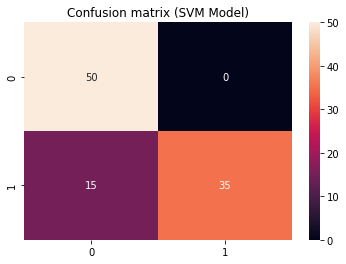

In [24]:
best_param_svm = study_svm.best_params
SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
y_pred_svm = SVM.predict(x_test_)

display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8500
Precision: 1.0000
Recall: 0.7000
F1 Score: 0.8235

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



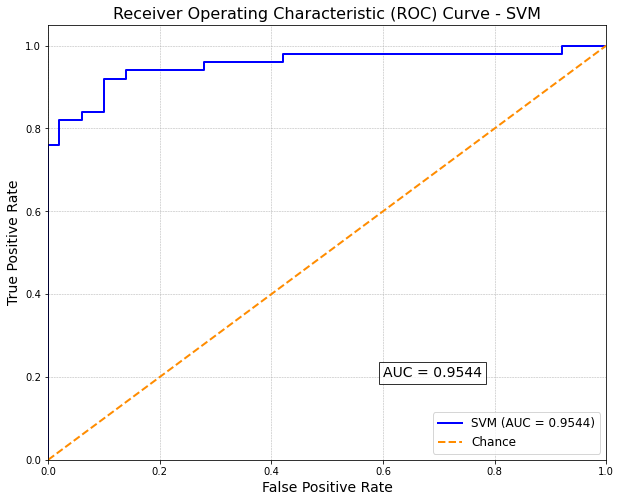

In [37]:
# Train the best SVM model
best_param_svm = study_svm.best_params
best_svm = SVC(**best_param_svm, random_state=123, probability=True).fit(x_train_,y_train)
best_svm.fit(x_train_, y_train)

# Predict on the test set
y_pred_svm = best_svm.predict(x_test_)
y_proba_svm = best_svm.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot the ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_svm:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

## Xgboost

In [26]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


In [27]:
pos_weight = y_train.sum() / (len(y_train) - y_train.sum())
pos_weight

0.03990374974934831

In [28]:
# Creating and running our optimization
study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")

with parallel_backend('threading'):
    study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1)

[I 2024-08-26 02:31:31,397] A new study created in memory with name: XGBoost
[I 2024-08-26 02:33:22,089] Trial 7 finished with value: 0.8767035626262453 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7432986813773907, 'colsample_bytree': 0.8933444769649508, 'reg_alpha': 0.06151818989158435, 'reg_lambda': 1.0186969733210314e-05}. Best is trial 7 with value: 0.8767035626262453.
[I 2024-08-26 02:33:23,645] Trial 0 finished with value: 0.858218679266985 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8752241233901363, 'colsample_bytree': 0.7275455179698086, 'reg_alpha': 0.01390602809805095, 'reg_lambda': 9.542807627705615}. Best is trial 7 with value: 0.8767035626262453.
[I 2024-08-26 02:33:56,355] Trial 2 finished with value: 0.8868041782286993 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.7721444608201563, 'colsample_bytree': 0.5311100496802348, 'reg_alpha': 6.361604510148299, 'reg_lambda': 0.027166782193632288}. Bes

In [29]:
# Evaluating our Optuna Trial
print("Best trial:", study_xgb.best_trial.number)
print("Best accuracy:", study_xgb.best_trial.value)
print("Best hyperparameters:", study_xgb.best_params)


Best trial: 14
Best accuracy: 0.9187775633909208
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7250458061763512, 'colsample_bytree': 0.8753982798957336, 'reg_alpha': 0.0037771004469676103, 'reg_lambda': 0.00014559569161899522}


              precision    recall  f1-score   support

           0       0.79      1.00      0.88        50
           1       1.00      0.74      0.85        50

    accuracy                           0.87       100
   macro avg       0.90      0.87      0.87       100
weighted avg       0.90      0.87      0.87       100



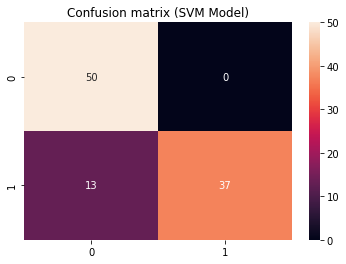

In [38]:
# Train the best XGBoost model
best_param_xgb = study_xgb.best_params
best_xgb = xgb.XGBClassifier(**best_param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
xgb=best_xgb.fit(x_train_, y_train)
y_pred_xgb = xgb.predict(x_test_)

display_results(y_test, y_pred_xgb, cm_title = "Confusion matrix (SVM Model)")


Accuracy: 0.8700
Precision: 1.0000
Recall: 0.7400
F1 Score: 0.8506

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        50
           1       1.00      0.74      0.85        50

    accuracy                           0.87       100
   macro avg       0.90      0.87      0.87       100
weighted avg       0.90      0.87      0.87       100



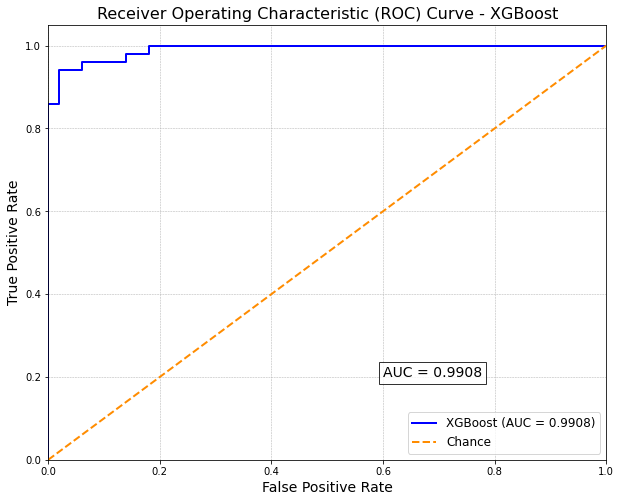

In [31]:
# Predict on the test set
y_pred_xgb = best_xgb.predict(x_test_)
y_proba_xgb = best_xgb.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_xgb:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# 5. Models Comparison

The ROC-Curve plot provides us with a clear view to choose the best model, as it is evident that the decision tree model has the largest area under the curve. Therefore, based on the ROC , the decision tree model is selected as the best model.

In [51]:
# Create a dictionary to store the metrics for each model
metrics_summary = {
    "Model": ["KNN", "SVM", "LR", "DecT", "XGB"],
    "Accuracy": [accuracy_knn, accuracy_svm, accuracy_lr, accuracy_dect, accuracy_xgb],
    "Recall": [recall_knn, recall_svm, recall_lr, recall_dect, recall_xgb],
    "Precision": [precision_knn, precision_svm, precision_lr, precision_dect, precision_xgb],
    "F1-Score": [f1_knn, f1_svm, f1_lr, f1_dect, f1_xgb],
    "AUC": [roc_auc_lr, roc_auc_svm, roc_auc_knn, roc_auc_dect, roc_auc_xgb]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the DataFrame
metrics_df


,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,KNN,0.80,0.60,1.0,0.750000,0.9140
1,SVM,0.85,0.70,1.0,0.823529,0.9544
2,LR,0.51,0.02,1.0,0.039216,0.8000
3,DecT,0.84,0.68,1.0,0.809524,0.9414
4,XGB,0.87,0.74,1.0,0.850575,0.9908


In [52]:
metrics_df.to_excel('result/10.xlsx', index=False)

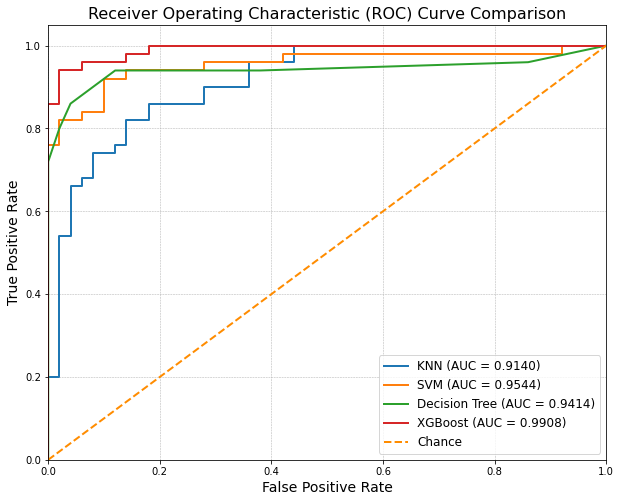

In [44]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for KNN
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'KNN (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Plot ROC curve for Logistic Regression
#plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for Decision Tree
plt.plot(fpr_dect, tpr_dect, lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()
